<a href="https://colab.research.google.com/github/BossRocket/parallelization-of-machine-learning/blob/main/ParallelGarageUCF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Parallelized Machine Learning With Mini-Batch Stochastic Gradient Descent**
## Import Necessary Python Libraries
For our project we need a couple libraries. Numpy and pandas are necesarry for data navigation and manipulation. Pyplot is used to display our results into graphs. Multiprocessing and Pools class are used to conccurently execute our Quadratic Regression calculations. Time is used to track time intervals to observe code execution time. Files are uploaded using google.colab files class.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from multiprocessing import Pool
import multiprocessing
import time
import sklearn
from google.colab import files
uploaded = files.upload()

## Function [Gradientdescent]: Mini-Batch Stochastic Gradient Descent
Below is our code implementation for Mini-Batch Stochastic Gradient Descent. This function takes in parameters for:


*   Dataset (written as garagemanip)
*   Epochs - signifying number of iterations to loop through
*   Batchsize & N - equal to size of the batch (we use 100 for this implementation)
*   a, b, and c (initial parameter values that we found work best)
*   L1, L2, and L3 (initial individual learing rates values that we found work best)

To create random minibatches of data, we take the first batchsize # of elements for the time and percentage occupancy (X and Y respectively). Then we shuffle the dataset so that the next epochs batch is randomized. 

We then use new x variable and the curernt values of parameters a, b, and c to compute y_pred which is the computed function to predict y values. 

Gradients d_a, d_b, and d_c are then computed using x, y, and y_pred. These gradients are now used to calculate the new values for a, b, and c by subtracting them with the gradient multiplied by the individual learning rate.

Finally the calculated parameters are returned as a list.




In [ ]:
def Gradientdescent(datasets, epochs = 5000, batchsize = 10, n = float(10) , a = -1, b = 0, c = -50, L1 = 0.00001,L2= 0.00005,L3 = 0.00008):
    for i in range(epochs):
        #set x and y and shuffle
        datasets = datasets.sample(frac=1).reset_index(drop=True)
        x = datasets['Military_Time'][:batchsize]
        y = datasets['Percentage_Occupied'][:batchsize]
        y_pred = a*(x**2) + b*(x) + c
        d_a = (-2/n) * sum(x**2 * (y - y_pred))
        d_b = (-2/n) * sum(x * (y - y_pred))
        d_c = (-2/n) * sum(y - y_pred)
        ##updating paramters using specific learning rates for each parameter.
        a = a - (L1 * d_a)
        b = b - (L2 * d_b)
        c = c - (L3 * d_c)
    return a,b,c

## Function [garagecalc]: Parent Function
Below is the code for our parent function that is used to do all tasks other than the gradient descent calculations. This function takes in the garage and day of the week as parameters that it then uses to split up and clean the dataset. 

This function is also responsible for spawning the processors and having them comlete the GradienDescent function for the desired garage and day of the week.

This function also uses the Time library to keep track of how long the parallelized implemntation takes vs sequential.

After calling both versions, the resulting parameters are displayed along with a graph to display the accuracy of the parallel-computed parameters.

In [ ]:
def garagecalc(garage1, dayofweek1):
    garage = garage1
    dayofweek = dayofweek1

    gar = np.array(data2.iloc[:, 0]) # All garages
    day = np.array(data2.iloc[:, 2]) # All days
    ##split data to focus on user inputed date and garage.
    garageA = data2.loc[(day == dayofweek1) & (gar == garage1) ]

    ##filter out entries before and after 6am - 8pm time frame
    garageAmanip = garageA[(garageA['Percentage_Occupied'] >= 10 ) & ((garageA['Military_Time'] <= 1200) & (360 <=garageA['Military_Time']))]

    ## sort manipulated table
    garageAmanip = garageAmanip.sort_values(by=['Military_Time'], axis = 0)
    garageAmanip = garageAmanip.reset_index()
    garageAmanip['Military_Time'] = garageAmanip['Military_Time'].div(60)

    # This line randomizes the table rows 
    garageAmanip = garageAmanip.sample(frac=1).reset_index(drop=True)

    pooliterate = []
    for j in range(multiprocessing.cpu_count()):
        garageAmanip = garageAmanip.sample(frac=1).reset_index(drop=True)
        pooliterate.append(garageAmanip)


    start = time.time()
    with Pool(multiprocessing.cpu_count()) as p:
        result = p.map(Gradientdescent, pooliterate)
    end = time.time()
    print(result)
    print('This calculation with multiprocessing on {} cores took {} seconds\n'.format(multiprocessing.cpu_count(), end - start))

    start1 = time.time()
    result2 = Gradientdescent(garageAmanip, epochs = 10000)
    end1 = time.time()
    print('This calculation without multiprocessing took {} seconds\n'.format( end1 - start1))


    print('Parameters from non-parallel gradient descent:\n {}\n'.format(result2))
    df = pd.DataFrame(result,columns=['Parameter A','Parameter B','Parameter C'])
    print('results from parellelized gradient descent:\n {}\n'.format(df))


    a = df["Parameter A"].mean()
    b = df["Parameter B"].mean()
    c = df["Parameter C"].mean()

    # # Generate prediction graph

    ## this is for if you want to take the average at the end if you didnt above for the occupancy graph to show only one line
    garageAmanip = garageAmanip.groupby(['Military_Time'])
    garageAmanip = garageAmanip.mean()
    garageAmanip = garageAmanip.reset_index()

    x = garageAmanip.Military_Time
    y = garageAmanip.Percentage_Occupied
    y_pred = a*(x**2) + b*(x) + c
    y_pred2 = (result2[0])*(x**2) + (result2[1])*(x) + result2[2]
    plt.scatter(x,y, label='Dataset')
    plt.scatter(x, y_pred2, color='green', label='Sequential')
    plt.scatter(x, y_pred, color='red', label='Parallel') # Predicted values in red
    plt.legend(loc="upper left")
    plt.title("Average Percentage Occupancy vs. Time Graph for {} on {}".format(garage, dayofweek))
    plt.xlabel("Hour")
    plt.ylabel("Average Percent Occupied")
    plt.show()

## How many threads are availabe to us?
Below we see how many processors are available to use for us through google colabs CPU. The tasks will be split up between this many processors.

In [ ]:
print(multiprocessing.cpu_count())

2


## Reading in The Dataset
We start by reading in the dataset using pandas read_csv method. The read data is transfered to data2 variable. Lets also observe the the dataset by using data2.head() to display how the general layout of the dataset is.

In [ ]:
data2 = pd.read_csv("UpdatedData_1.csv")
# data2 = pd.read_csv("TestData.csv")

In [ ]:
data2.head()

,Garage,Percentage_Occupied,Day_of_week,Military_Time
0,Garage A,0.616143,Thursday,930
1,Garage B,54.328832,Thursday,930
2,Garage C,61.663067,Thursday,930
3,Garage D,28.847703,Thursday,930
4,Garage H,54.984424,Thursday,930


# Computing Quadratic Regression for each day of the week / Garage combination

Below is a simple for loop to call the garagecalc function for every day of the week and garage combination from the dataset.

[(-0.11636856696616384, 5.3204172284716655, -49.009088065741615), (-0.09660637477443211, 5.303081618996539, -49.013219133625405)]
This calculation with multiprocessing on 2 cores took 14.846228122711182 seconds

This calculation without multiprocessing took 18.28828716278076 seconds

Parameters from non-parallel gradient descent:
 (-0.15431643329678682, 6.29039350363522, -48.82111454357748)

results from parellelized gradient descent:
    Parameter A  Parameter B  Parameter C
0    -0.116369     5.320417   -49.009088
1    -0.096606     5.303082   -49.013219



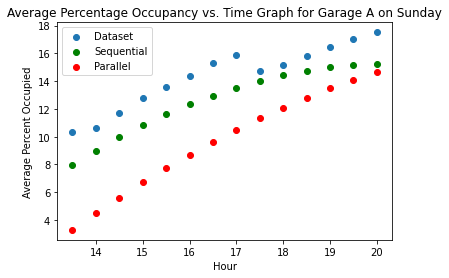

[(-0.7184418932736596, 17.929236959489206, -45.862686024048486), (-0.5869901893037294, 17.956180892070744, -45.86572102332277)]
This calculation with multiprocessing on 2 cores took 15.14428997039795 seconds

This calculation without multiprocessing took 17.698282480239868 seconds

Parameters from non-parallel gradient descent:
 (-0.7032326830651601, 18.16039708562126, -45.872330588980915)

results from parellelized gradient descent:
    Parameter A  Parameter B  Parameter C
0    -0.718442    17.929237   -45.862686
1    -0.586990    17.956181   -45.865721



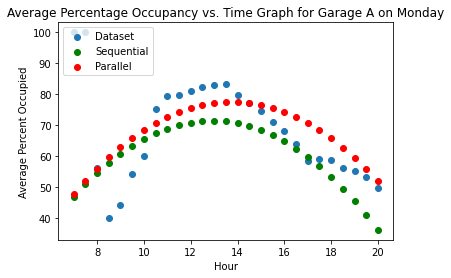

[(-0.7026144361625013, 18.635811840986477, -45.766952251104456), (-0.7005499439441152, 18.68248152592262, -45.74928989913132)]
This calculation with multiprocessing on 2 cores took 15.24587869644165 seconds

This calculation without multiprocessing took 17.699921369552612 seconds

Parameters from non-parallel gradient descent:
 (-0.6808589972038646, 18.77966401051016, -45.83727514918242)

results from parellelized gradient descent:
    Parameter A  Parameter B  Parameter C
0    -0.702614    18.635812   -45.766952
1    -0.700550    18.682482   -45.749290



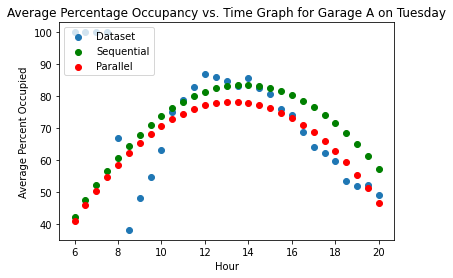

[(-0.6710153506962722, 18.38494481996652, -45.649351487030465), (-0.718439940266862, 18.527299151327007, -45.610622544345354)]
This calculation with multiprocessing on 2 cores took 15.344431161880493 seconds

This calculation without multiprocessing took 17.502579927444458 seconds

Parameters from non-parallel gradient descent:
 (-0.6981603804842585, 18.810876062950502, -45.510268457300064)

results from parellelized gradient descent:
    Parameter A  Parameter B  Parameter C
0    -0.671015    18.384945   -45.649351
1    -0.718440    18.527299   -45.610623



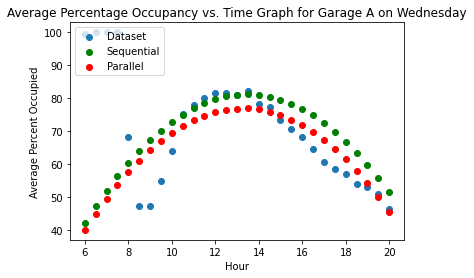

[(-0.6953072115782913, 17.842871700482636, -45.80841721965555), (-0.7158377191164451, 17.88110355103049, -45.782901116603654)]
This calculation with multiprocessing on 2 cores took 15.248008728027344 seconds

This calculation without multiprocessing took 17.785369634628296 seconds

Parameters from non-parallel gradient descent:
 (-0.71861145219524, 18.13816554769739, -45.728460316666855)

results from parellelized gradient descent:
    Parameter A  Parameter B  Parameter C
0    -0.695307    17.842872   -45.808417
1    -0.715838    17.881104   -45.782901



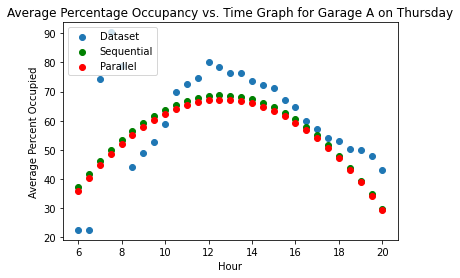

[(-0.4693569666600264, 13.040052438981816, -46.49746402219583), (-0.48723484223098434, 12.993288660743206, -46.53069099667568)]
This calculation with multiprocessing on 2 cores took 15.344108581542969 seconds

This calculation without multiprocessing took 17.525508642196655 seconds

Parameters from non-parallel gradient descent:
 (-0.41688184178775606, 13.320268982420908, -46.02974778898688)

results from parellelized gradient descent:
    Parameter A  Parameter B  Parameter C
0    -0.469357    13.040052   -46.497464
1    -0.487235    12.993289   -46.530691



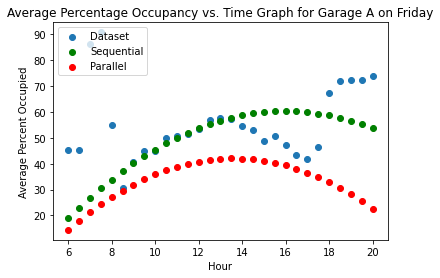

[(-0.23594131685318645, 9.04819229511971, -47.89566613499564), (-0.19977186023518387, 9.077073918848146, -47.881819942445524)]
This calculation with multiprocessing on 2 cores took 15.150497436523438 seconds

This calculation without multiprocessing took 17.938109874725342 seconds

Parameters from non-parallel gradient descent:
 (-0.25427428527729823, 9.264889052160191, -47.73996965336433)

results from parellelized gradient descent:
    Parameter A  Parameter B  Parameter C
0    -0.235941     9.048192   -47.895666
1    -0.199772     9.077074   -47.881820



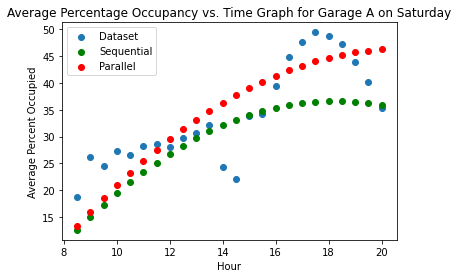

[(-0.29353403469563333, 9.19230843032803, -47.64947321518965), (-0.30258119204572875, 9.210660539765284, -47.647614417344)]
This calculation with multiprocessing on 2 cores took 15.245888948440552 seconds

This calculation without multiprocessing took 17.73646330833435 seconds

Parameters from non-parallel gradient descent:
 (-0.3123385909721759, 9.408390953319765, -47.399944912098114)

results from parellelized gradient descent:
    Parameter A  Parameter B  Parameter C
0    -0.293534     9.192308   -47.649473
1    -0.302581     9.210661   -47.647614



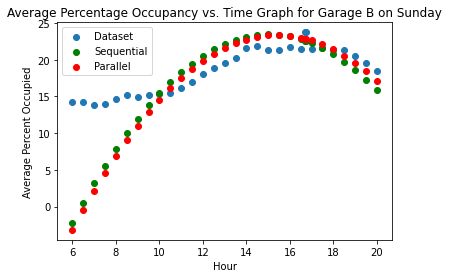

[(-0.6748764582811524, 17.36242570903134, -46.24602315409432), (-0.5716998116770062, 17.275782802317533, -46.267351078241575)]
This calculation with multiprocessing on 2 cores took 15.449048280715942 seconds

This calculation without multiprocessing took 17.697267770767212 seconds

Parameters from non-parallel gradient descent:
 (-0.602552092010996, 17.699832925640294, -46.73401763213491)

results from parellelized gradient descent:
    Parameter A  Parameter B  Parameter C
0    -0.674876    17.362426   -46.246023
1    -0.571700    17.275783   -46.267351



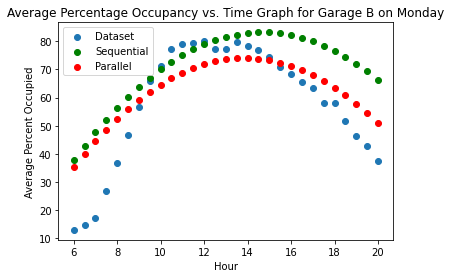

[(-0.6621129108233543, 18.08849959018532, -46.133105990020105), (-0.7160081496122596, 18.089914406870662, -46.13242119603095)]
This calculation with multiprocessing on 2 cores took 15.347112894058228 seconds

This calculation without multiprocessing took 17.716134071350098 seconds

Parameters from non-parallel gradient descent:
 (-0.7445399109513111, 18.359640247042716, -46.64389750920674)

results from parellelized gradient descent:
    Parameter A  Parameter B  Parameter C
0    -0.662113    18.088500   -46.133106
1    -0.716008    18.089914   -46.132421



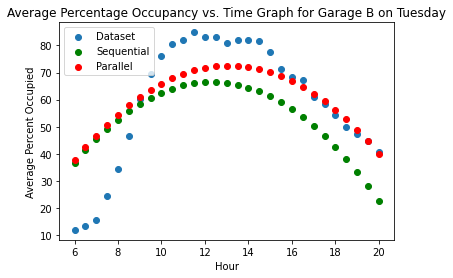

[(-0.6459744129543566, 17.45717219347047, -46.10405853372566), (-0.6203096586261301, 17.53775972664963, -46.09673263543878)]
This calculation with multiprocessing on 2 cores took 15.551082134246826 seconds

This calculation without multiprocessing took 17.831502437591553 seconds

Parameters from non-parallel gradient descent:
 (-0.7113500466164108, 17.692107166245155, -46.484069367717716)

results from parellelized gradient descent:
    Parameter A  Parameter B  Parameter C
0    -0.645974    17.457172   -46.104059
1    -0.620310    17.537760   -46.096733



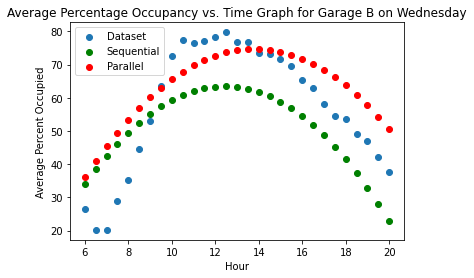

[(-0.7168347466561669, 17.931317303604416, -46.144749669270894), (-0.6512372105737839, 18.04465266278102, -46.093535110751496)]
This calculation with multiprocessing on 2 cores took 15.549584865570068 seconds

This calculation without multiprocessing took 17.852014780044556 seconds

Parameters from non-parallel gradient descent:
 (-0.6728641056822171, 18.291308741047388, -46.598087222828745)

results from parellelized gradient descent:
    Parameter A  Parameter B  Parameter C
0    -0.716835    17.931317   -46.144750
1    -0.651237    18.044653   -46.093535



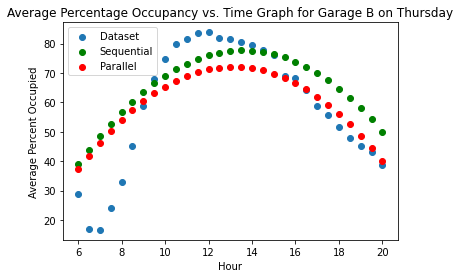

[(-0.7621277979749711, 18.049110970527973, -46.00329269954273), (-0.7169045048360195, 18.09516747388158, -45.99147951401927)]
This calculation with multiprocessing on 2 cores took 15.449020147323608 seconds

This calculation without multiprocessing took 17.807597398757935 seconds

Parameters from non-parallel gradient descent:
 (-0.7667230920052825, 18.20723005347451, -46.42052007643618)

results from parellelized gradient descent:
    Parameter A  Parameter B  Parameter C
0    -0.762128    18.049111   -46.003293
1    -0.716905    18.095167   -45.991480



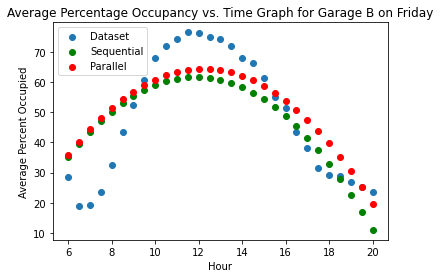

[(-0.24414684759931787, 9.846163929700806, -47.62157244813188), (-0.32775774281528214, 9.82979907314616, -47.62723913940732)]
This calculation with multiprocessing on 2 cores took 15.245733976364136 seconds

This calculation without multiprocessing took 17.662646293640137 seconds

Parameters from non-parallel gradient descent:
 (-0.27595731542094354, 10.053690160838444, -47.49059940933568)

results from parellelized gradient descent:
    Parameter A  Parameter B  Parameter C
0    -0.244147     9.846164   -47.621572
1    -0.327758     9.829799   -47.627239



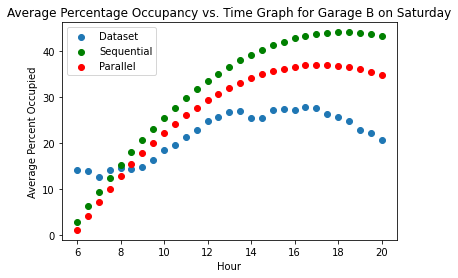

[(0.049214033181962547, 3.0049497251784967, -49.42169815918737), (0.04836756468192362, 3.009990019060197, -49.420401487454264)]
This calculation with multiprocessing on 2 cores took 14.948336601257324 seconds

This calculation without multiprocessing took 17.932316541671753 seconds

Parameters from non-parallel gradient descent:
 (-0.07025464050328215, 4.723970685886504, -49.06740129107562)

results from parellelized gradient descent:
    Parameter A  Parameter B  Parameter C
0     0.049214      3.00495   -49.421698
1     0.048368      3.00999   -49.420401



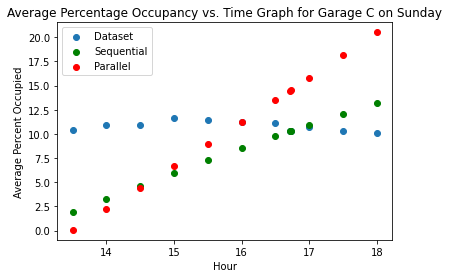

[(-0.6532907301191802, 16.87438103687971, -46.38004360888261), (-0.6077529754424412, 16.875731251964247, -46.38183927658333)]
This calculation with multiprocessing on 2 cores took 15.446906328201294 seconds

This calculation without multiprocessing took 17.48886275291443 seconds

Parameters from non-parallel gradient descent:
 (-0.5647866378081922, 17.23341183763963, -46.69628760515991)

results from parellelized gradient descent:
    Parameter A  Parameter B  Parameter C
0    -0.653291    16.874381   -46.380044
1    -0.607753    16.875731   -46.381839



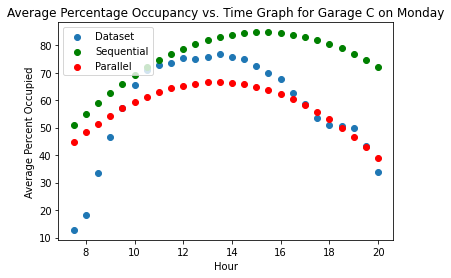

[(-0.6370933819732081, 17.02368071779548, -46.255073772105646), (-0.626628757605488, 17.04385903951689, -46.25197185810207)]
This calculation with multiprocessing on 2 cores took 15.350852489471436 seconds

This calculation without multiprocessing took 17.676939249038696 seconds

Parameters from non-parallel gradient descent:
 (-0.6666270863438042, 17.27996313927244, -46.49411659987037)

results from parellelized gradient descent:
    Parameter A  Parameter B  Parameter C
0    -0.637093    17.023681   -46.255074
1    -0.626629    17.043859   -46.251972



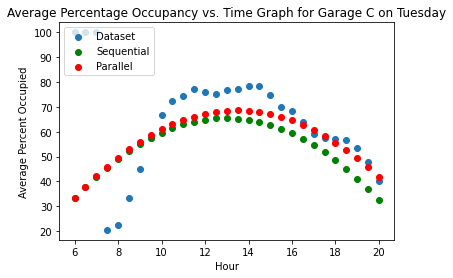

[(-0.6845525527555726, 17.260383343209142, -46.16471917250282), (-0.6586761858242449, 17.20839027815405, -46.181601810718995)]
This calculation with multiprocessing on 2 cores took 15.347946643829346 seconds

This calculation without multiprocessing took 17.953446865081787 seconds

Parameters from non-parallel gradient descent:
 (-0.6587734847081375, 17.543043850887152, -46.382337563197005)

results from parellelized gradient descent:
    Parameter A  Parameter B  Parameter C
0    -0.684553    17.260383   -46.164719
1    -0.658676    17.208390   -46.181602



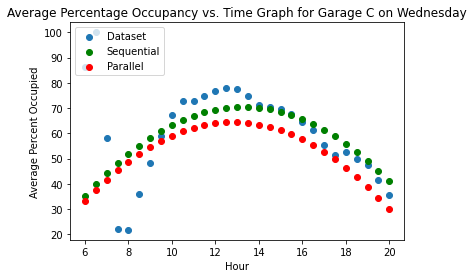

[(-0.5596346505010544, 16.28623094790329, -46.454330176813514), (-0.528291498491797, 16.28522152104523, -46.44896331058234)]
This calculation with multiprocessing on 2 cores took 15.650134086608887 seconds

This calculation without multiprocessing took 18.281770706176758 seconds

Parameters from non-parallel gradient descent:
 (-0.6392869659829806, 16.39077155630324, -46.74370672401656)

results from parellelized gradient descent:
    Parameter A  Parameter B  Parameter C
0    -0.559635    16.286231   -46.454330
1    -0.528291    16.285222   -46.448963



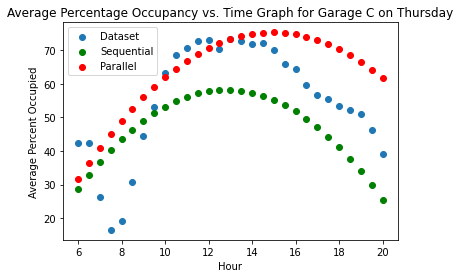

[(-0.6427402422881628, 16.2113438508536, -46.27869578598016), (-0.6747355112623896, 16.06575588527196, -46.31320776017334)]
This calculation with multiprocessing on 2 cores took 15.85493540763855 seconds

This calculation without multiprocessing took 17.94857621192932 seconds

Parameters from non-parallel gradient descent:
 (-0.6951935682351368, 16.423545607425112, -46.3451869705292)

results from parellelized gradient descent:
    Parameter A  Parameter B  Parameter C
0    -0.642740    16.211344   -46.278696
1    -0.674736    16.065756   -46.313208



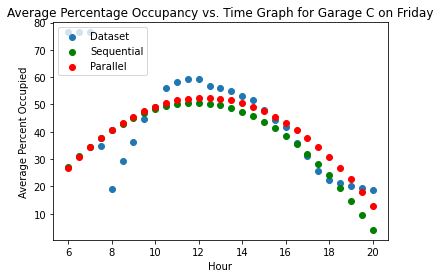

[(-0.19271267018712282, 7.279338914927535, -48.27547374504925), (-0.17854561988590759, 7.406053176785861, -48.25450947087786)]
This calculation with multiprocessing on 2 cores took 15.151105403900146 seconds

This calculation without multiprocessing took 18.458017110824585 seconds

Parameters from non-parallel gradient descent:
 (-0.18023241575685098, 7.770923435468835, -48.04754210678201)

results from parellelized gradient descent:
    Parameter A  Parameter B  Parameter C
0    -0.192713     7.279339   -48.275474
1    -0.178546     7.406053   -48.254509



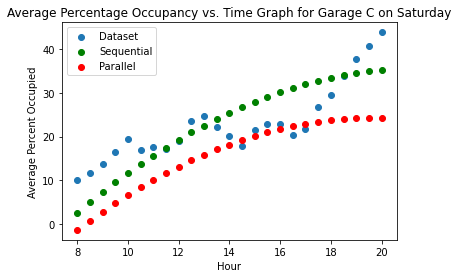

[(-0.5637244524102689, 13.751586461761844, -46.338781164287646), (-0.5929741648608055, 13.736781071396406, -46.33776557738658)]
This calculation with multiprocessing on 2 cores took 15.067471265792847 seconds

This calculation without multiprocessing took 18.130481004714966 seconds

Parameters from non-parallel gradient descent:
 (-0.6027593931097397, 14.019525044675008, -45.932369575525755)

results from parellelized gradient descent:
    Parameter A  Parameter B  Parameter C
0    -0.563724    13.751586   -46.338781
1    -0.592974    13.736781   -46.337766



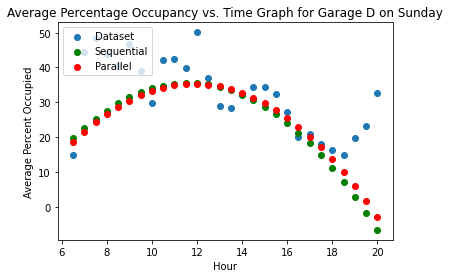

[(-0.6781583381872824, 16.707612289565077, -46.2392780161868), (-0.7024144262228317, 16.74779385766058, -46.2330278817067)]
This calculation with multiprocessing on 2 cores took 15.54845666885376 seconds

This calculation without multiprocessing took 17.5923490524292 seconds

Parameters from non-parallel gradient descent:
 (-0.6605248447975895, 16.885621338093237, -46.43289474049688)

results from parellelized gradient descent:
    Parameter A  Parameter B  Parameter C
0    -0.678158    16.707612   -46.239278
1    -0.702414    16.747794   -46.233028



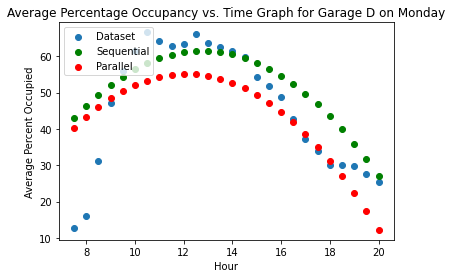

[(-0.6741037417268295, 16.929904313287768, -46.29618959259624), (-0.6909824697648078, 16.964073726673607, -46.29034381501206)]
This calculation with multiprocessing on 2 cores took 15.251646041870117 seconds

This calculation without multiprocessing took 17.600939750671387 seconds

Parameters from non-parallel gradient descent:
 (-0.6686921375660488, 17.244860979374543, -46.532845853468)

results from parellelized gradient descent:
    Parameter A  Parameter B  Parameter C
0    -0.674104    16.929904   -46.296190
1    -0.690982    16.964074   -46.290344



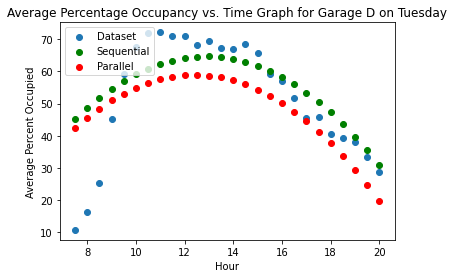

[(-0.6155175241972834, 16.30927363397295, -46.314745827964416), (-0.650770519741413, 16.31336753917506, -46.30364087497914)]
This calculation with multiprocessing on 2 cores took 15.450127124786377 seconds

This calculation without multiprocessing took 17.819840908050537 seconds

Parameters from non-parallel gradient descent:
 (-0.6718719597264579, 16.545602531327795, -46.44018292746711)

results from parellelized gradient descent:
    Parameter A  Parameter B  Parameter C
0    -0.615518    16.309274   -46.314746
1    -0.650771    16.313368   -46.303641



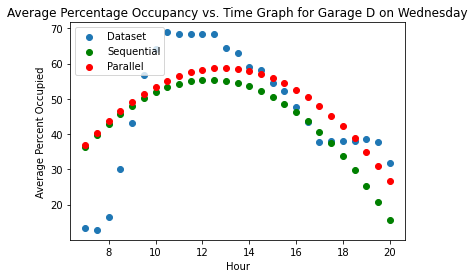

[(-0.5868048549224594, 15.845367340775066, -46.4625938649687), (-0.6017357115715816, 15.854484897641747, -46.45941280125828)]
This calculation with multiprocessing on 2 cores took 15.347411394119263 seconds

This calculation without multiprocessing took 17.85807704925537 seconds

Parameters from non-parallel gradient descent:
 (-0.6721144044224789, 16.107360621258497, -46.64490088934791)

results from parellelized gradient descent:
    Parameter A  Parameter B  Parameter C
0    -0.586805    15.845367   -46.462594
1    -0.601736    15.854485   -46.459413



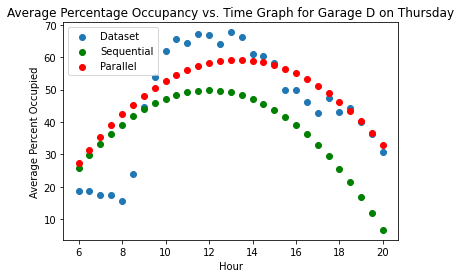

[(-0.5654263788175837, 14.73396325725273, -46.32666138364813), (-0.6049974087413033, 14.63761021231371, -46.35340015292341)]
This calculation with multiprocessing on 2 cores took 15.550563097000122 seconds

This calculation without multiprocessing took 17.728575706481934 seconds

Parameters from non-parallel gradient descent:
 (-0.6509231232962707, 14.94857715327112, -46.12002395903766)

results from parellelized gradient descent:
    Parameter A  Parameter B  Parameter C
0    -0.565426    14.733963   -46.326661
1    -0.604997    14.637610   -46.353400



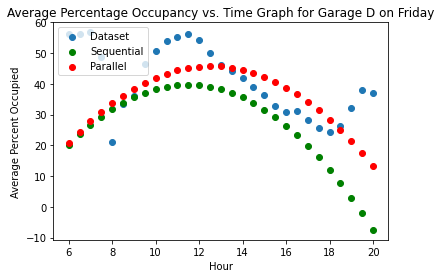

[(-0.4373466178609763, 12.162623230667267, -47.03878969993875), (-0.4814169326068011, 12.07454061400091, -47.06341258340822)]
This calculation with multiprocessing on 2 cores took 15.158458709716797 seconds

This calculation without multiprocessing took 18.045252799987793 seconds

Parameters from non-parallel gradient descent:
 (-0.4959542073163741, 12.322989631737984, -46.84373057797497)

results from parellelized gradient descent:
    Parameter A  Parameter B  Parameter C
0    -0.437347    12.162623   -47.038790
1    -0.481417    12.074541   -47.063413



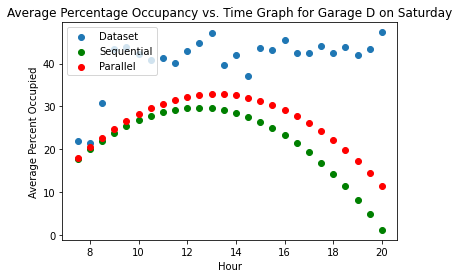

[(-0.25814275077643023, 7.595708200816011, -48.352316161058475), (-0.1809993318237058, 7.651537863021314, -48.33290532715648)]
This calculation with multiprocessing on 2 cores took 14.745140552520752 seconds

This calculation without multiprocessing took 18.222206115722656 seconds

Parameters from non-parallel gradient descent:
 (-0.27747980604297456, 8.078150803134099, -48.184712804906745)

results from parellelized gradient descent:
    Parameter A  Parameter B  Parameter C
0    -0.258143     7.595708   -48.352316
1    -0.180999     7.651538   -48.332905



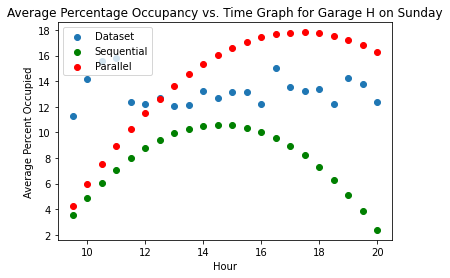

[(-0.651656179107236, 17.617423887944124, -45.97797240861752), (-0.7108661637222673, 17.519112902355772, -46.014166198568994)]
This calculation with multiprocessing on 2 cores took 15.24430775642395 seconds

This calculation without multiprocessing took 17.850570678710938 seconds

Parameters from non-parallel gradient descent:
 (-0.6305692796635279, 17.731796317831048, -46.190095866186105)

results from parellelized gradient descent:
    Parameter A  Parameter B  Parameter C
0    -0.651656    17.617424   -45.977972
1    -0.710866    17.519113   -46.014166



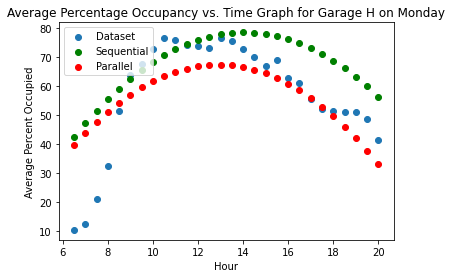

[(-0.7488770513149362, 17.959543685786997, -45.972237302426684), (-0.6138133778562447, 17.99847084408425, -45.97315139876504)]
This calculation with multiprocessing on 2 cores took 15.34592890739441 seconds

This calculation without multiprocessing took 17.58798122406006 seconds

Parameters from non-parallel gradient descent:
 (-0.7407821516730309, 18.15827815090752, -46.19271956153753)

results from parellelized gradient descent:
    Parameter A  Parameter B  Parameter C
0    -0.748877    17.959544   -45.972237
1    -0.613813    17.998471   -45.973151



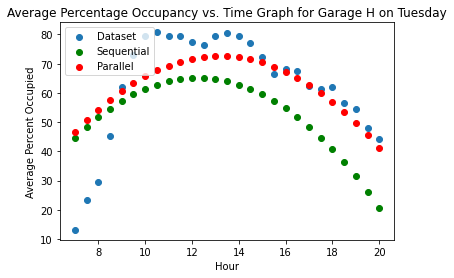

[(-0.6363420222773072, 18.001567007802965, -45.81145619654941), (-0.7300221403037432, 17.8907784084255, -45.8153539856017)]
This calculation with multiprocessing on 2 cores took 15.252566576004028 seconds

This calculation without multiprocessing took 17.644549131393433 seconds

Parameters from non-parallel gradient descent:
 (-0.6952627653231522, 18.217352969343672, -45.886303154106336)

results from parellelized gradient descent:
    Parameter A  Parameter B  Parameter C
0    -0.636342    18.001567   -45.811456
1    -0.730022    17.890778   -45.815354



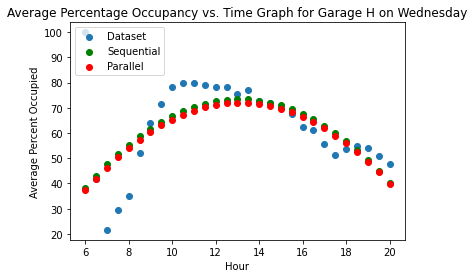

[(-0.5656639713723122, 17.124611277460875, -46.121743061765784), (-0.662686859867892, 17.036019603534, -46.128707196655775)]
This calculation with multiprocessing on 2 cores took 15.453387022018433 seconds

This calculation without multiprocessing took 17.74041247367859 seconds

Parameters from non-parallel gradient descent:
 (-0.6557537042964271, 17.189664920456806, -46.42820055041804)

results from parellelized gradient descent:
    Parameter A  Parameter B  Parameter C
0    -0.565664    17.124611   -46.121743
1    -0.662687    17.036020   -46.128707



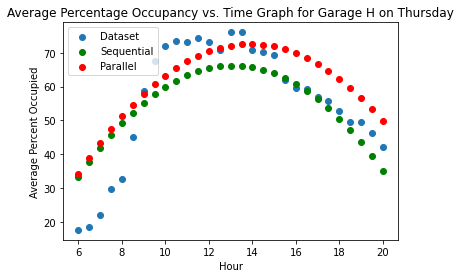

[(-0.7731254154614081, 17.148667363986288, -45.91752320206098), (-0.6914232738579039, 17.066793951421253, -45.943996664473886)]
This calculation with multiprocessing on 2 cores took 15.555227756500244 seconds

This calculation without multiprocessing took 17.411256074905396 seconds

Parameters from non-parallel gradient descent:
 (-0.7494930316235825, 17.49883940625527, -45.8716878123362)

results from parellelized gradient descent:
    Parameter A  Parameter B  Parameter C
0    -0.773125    17.148667   -45.917523
1    -0.691423    17.066794   -45.943997



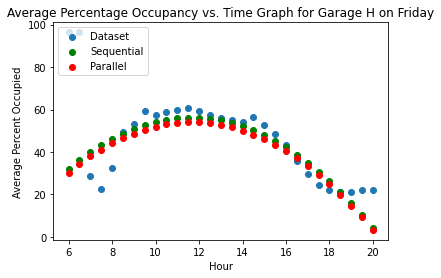

[(-0.14277118774358022, 8.247866642465068, -47.95047017427942), (-0.14027225872018872, 8.249898899808949, -47.94475643635383)]
This calculation with multiprocessing on 2 cores took 14.94918704032898 seconds

This calculation without multiprocessing took 18.091834545135498 seconds

Parameters from non-parallel gradient descent:
 (-0.17937778631805376, 8.261344482752163, -47.75990630958057)

results from parellelized gradient descent:
    Parameter A  Parameter B  Parameter C
0    -0.142771     8.247867   -47.950470
1    -0.140272     8.249899   -47.944756



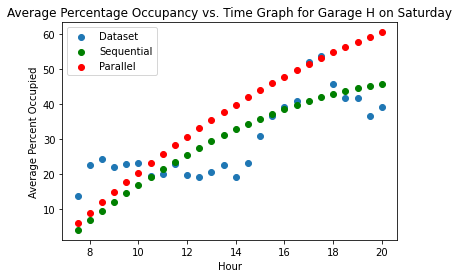

[(-0.05068306095956255, 4.32601971396786, -49.205164964028995), (-0.05140180432550882, 4.341354969674819, -49.20289997678667)]
This calculation with multiprocessing on 2 cores took 14.852716445922852 seconds

This calculation without multiprocessing took 18.304022073745728 seconds

Parameters from non-parallel gradient descent:
 (-0.14320754191338922, 5.972770680845443, -48.88937380437993)

results from parellelized gradient descent:
    Parameter A  Parameter B  Parameter C
0    -0.050683     4.326020   -49.205165
1    -0.051402     4.341355   -49.202900



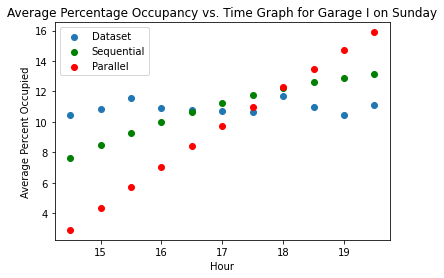

[(-0.6596047951480825, 17.481912424312128, -46.24595466030188), (-0.6971606050553317, 17.510576147222547, -46.229336630583816)]
This calculation with multiprocessing on 2 cores took 15.2456374168396 seconds

This calculation without multiprocessing took 17.67477321624756 seconds

Parameters from non-parallel gradient descent:
 (-0.7094316325389598, 17.856546727683845, -46.56609751762557)

results from parellelized gradient descent:
    Parameter A  Parameter B  Parameter C
0    -0.659605    17.481912   -46.245955
1    -0.697161    17.510576   -46.229337



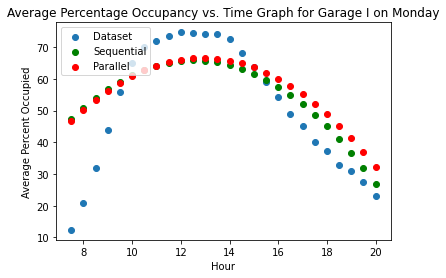

[(-0.6971854001525509, 18.35289505969721, -46.00182482658046), (-0.8033043836505009, 18.349092591825737, -45.99862323686726)]
This calculation with multiprocessing on 2 cores took 15.24778962135315 seconds

This calculation without multiprocessing took 17.606040000915527 seconds

Parameters from non-parallel gradient descent:
 (-0.8088839769439002, 18.63402385884222, -46.29337900265611)

results from parellelized gradient descent:
    Parameter A  Parameter B  Parameter C
0    -0.697185    18.352895   -46.001825
1    -0.803304    18.349093   -45.998623



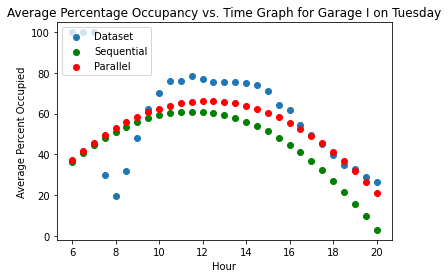

[(-0.7414617338367884, 17.71933969951309, -46.07413714806606), (-0.6611320707512027, 17.678360752101256, -46.08687083593336)]
This calculation with multiprocessing on 2 cores took 15.35640025138855 seconds

This calculation without multiprocessing took 17.64935326576233 seconds

Parameters from non-parallel gradient descent:
 (-0.7604438766805192, 18.00376473306212, -46.3163815428262)

results from parellelized gradient descent:
    Parameter A  Parameter B  Parameter C
0    -0.741462    17.719340   -46.074137
1    -0.661132    17.678361   -46.086871



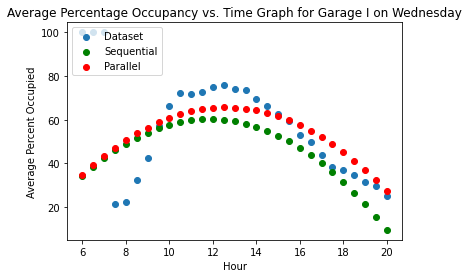

[(-0.6711532554610133, 16.719751987326866, -46.33407833108844), (-0.5655027721862222, 16.68822604030201, -46.35045622608073)]
This calculation with multiprocessing on 2 cores took 15.451563119888306 seconds

This calculation without multiprocessing took 17.5696804523468 seconds

Parameters from non-parallel gradient descent:
 (-0.654272628295941, 17.057842436503236, -46.57862376247701)

results from parellelized gradient descent:
    Parameter A  Parameter B  Parameter C
0    -0.671153    16.719752   -46.334078
1    -0.565503    16.688226   -46.350456



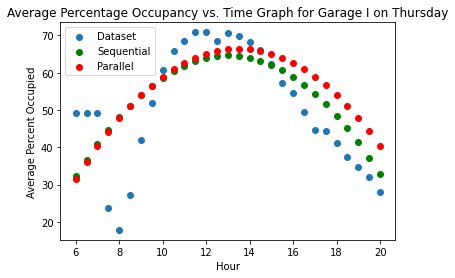

[(-0.5730434204804091, 14.542529563141274, -46.50082574322417), (-0.6060538538387883, 14.52779978016418, -46.50648658053674)]
This calculation with multiprocessing on 2 cores took 15.259830713272095 seconds

This calculation without multiprocessing took 17.58367395401001 seconds

Parameters from non-parallel gradient descent:
 (-0.6239834145935438, 14.981999586614059, -46.52841288411745)

results from parellelized gradient descent:
    Parameter A  Parameter B  Parameter C
0    -0.573043     14.54253   -46.500826
1    -0.606054     14.52780   -46.506487



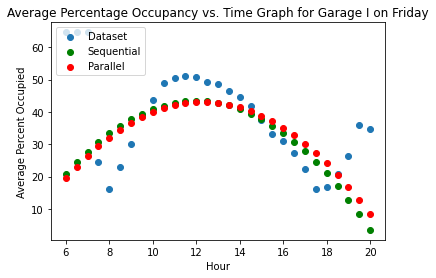

[(-0.21842241413743674, 10.444403373796353, -47.5456699453836), (-0.2718304443623971, 10.411368876863607, -47.55921513307854)]
This calculation with multiprocessing on 2 cores took 14.746250629425049 seconds

This calculation without multiprocessing took 17.94601583480835 seconds

Parameters from non-parallel gradient descent:
 (-0.3001413831409811, 10.760325877462945, -47.37753275192369)

results from parellelized gradient descent:
    Parameter A  Parameter B  Parameter C
0    -0.218422    10.444403   -47.545670
1    -0.271830    10.411369   -47.559215



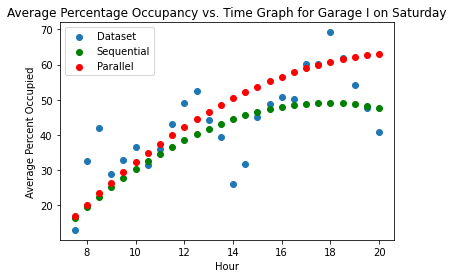

[(-0.5183043370087662, 14.32218558278773, -45.49776662791907), (-0.5108269761777835, 14.354840824583958, -45.50848085658908)]
This calculation with multiprocessing on 2 cores took 15.467963457107544 seconds

This calculation without multiprocessing took 17.65279984474182 seconds

Parameters from non-parallel gradient descent:
 (-0.559375564599109, 14.432847555099233, -44.660259384768295)

results from parellelized gradient descent:
    Parameter A  Parameter B  Parameter C
0    -0.518304    14.322186   -45.497767
1    -0.510827    14.354841   -45.508481



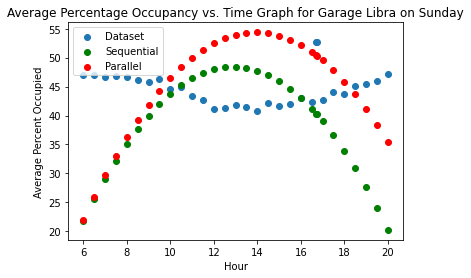

[(-0.6490410255197787, 18.439987730146928, -44.5123018160493), (-0.7511552832043602, 18.38495722174574, -44.47916455126301)]
This calculation with multiprocessing on 2 cores took 15.45134449005127 seconds

This calculation without multiprocessing took 17.930357456207275 seconds

Parameters from non-parallel gradient descent:
 (-0.7130783796534109, 18.29486593893691, -43.777362854445755)

results from parellelized gradient descent:
    Parameter A  Parameter B  Parameter C
0    -0.649041    18.439988   -44.512302
1    -0.751155    18.384957   -44.479165



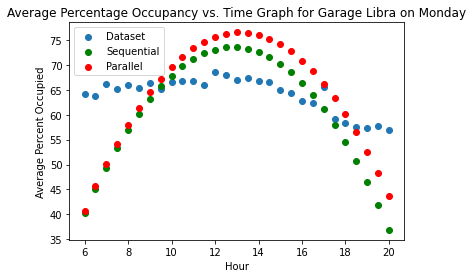

[(-0.6928235052497226, 18.560391405407767, -44.418455927804935), (-0.6624307710670024, 18.640246550168452, -44.39458802637508)]
This calculation with multiprocessing on 2 cores took 15.655031442642212 seconds

This calculation without multiprocessing took 17.803665161132812 seconds

Parameters from non-parallel gradient descent:
 (-0.7202906655211607, 18.552653075337446, -43.62165356556752)

results from parellelized gradient descent:
    Parameter A  Parameter B  Parameter C
0    -0.692824    18.560391   -44.418456
1    -0.662431    18.640247   -44.394588



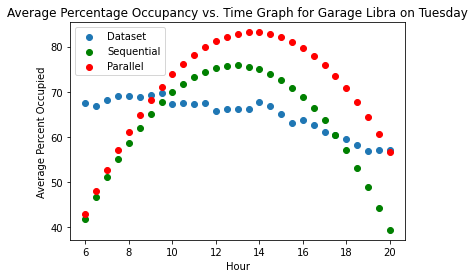

[(-0.6110732304171124, 18.24307562396135, -44.5808869948872), (-0.7397140302779857, 18.216017496993167, -44.6016670793779)]
This calculation with multiprocessing on 2 cores took 15.24757432937622 seconds

This calculation without multiprocessing took 17.768606662750244 seconds

Parameters from non-parallel gradient descent:
 (-0.8521114374646367, 18.13486478035211, -43.866693197228585)

results from parellelized gradient descent:
    Parameter A  Parameter B  Parameter C
0    -0.611073    18.243076   -44.580887
1    -0.739714    18.216017   -44.601667



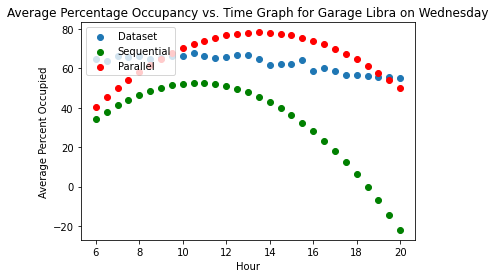

[(-0.7756530343791436, 18.545305735547373, -44.41113032129574), (-0.7390187101735942, 18.534368223122694, -44.40292167163592)]
This calculation with multiprocessing on 2 cores took 15.664555072784424 seconds

This calculation without multiprocessing took 18.076353788375854 seconds

Parameters from non-parallel gradient descent:
 (-0.6848277709278212, 18.67075156830433, -43.54347503934348)

results from parellelized gradient descent:
    Parameter A  Parameter B  Parameter C
0    -0.775653    18.545306   -44.411130
1    -0.739019    18.534368   -44.402922



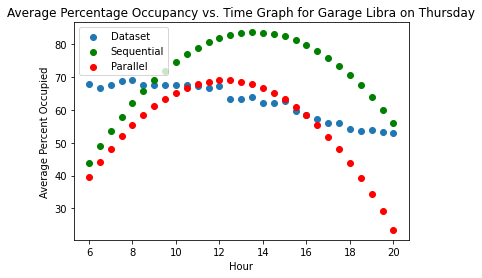

[(-0.7729466101515434, 18.330712582591804, -44.56144085828221), (-0.769641903095916, 18.23754682442231, -44.56122717840807)]
This calculation with multiprocessing on 2 cores took 15.345505952835083 seconds

This calculation without multiprocessing took 17.888996362686157 seconds

Parameters from non-parallel gradient descent:
 (-0.7212092075972241, 18.248813469708807, -43.855009470316205)

results from parellelized gradient descent:
    Parameter A  Parameter B  Parameter C
0    -0.772947    18.330713   -44.561441
1    -0.769642    18.237547   -44.561227



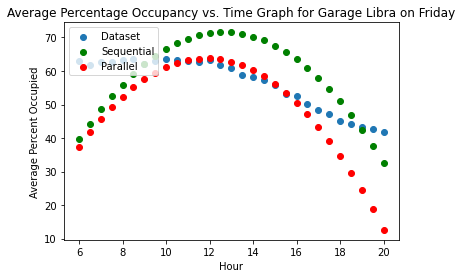

[(-0.5651143617642406, 14.924597438149343, -45.410833438853004), (-0.6340726157078167, 14.935553539384745, -45.41610516630959)]
This calculation with multiprocessing on 2 cores took 15.349400281906128 seconds

This calculation without multiprocessing took 17.889922618865967 seconds

Parameters from non-parallel gradient descent:
 (-0.6129698327543874, 15.100625226370127, -44.61547950655408)

results from parellelized gradient descent:
    Parameter A  Parameter B  Parameter C
0    -0.565114    14.924597   -45.410833
1    -0.634073    14.935554   -45.416105



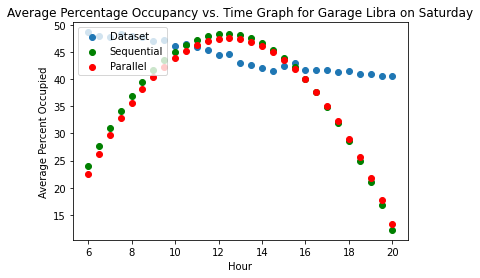

In [ ]:
# This cell runs garagecalc on each combination of garage & day

days = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"]
garages = ["Garage A", "Garage B", "Garage C", "Garage D", "Garage H", "Garage I", "Garage Libra"]

for i in garages:
    for j in days:
        garagecalc(i, j)

## Observing Results

### Accuracy
As we can see most of the graphs exibit good performance, particularly after the 12 hour mark. This might be becuase the slow decrease in garage occupancy as students leave campus fits much better to the quadratic shapped model we limited ourselves to. We definitely can see after these graphs that a polynomial regressino algorithm would have worked best, however this would have taken much longer to implement as we would have to train several more parameters and would need to figure out the order of the polynomial equation to implement which we have no idea how long it could take.

We can also see that when the dataset is focused around Garage Libra or on Sundays, the models tend to not predict correctly due to the abnormal shape of the datasets. This is caused by the lower than average occupancy as well as the data not following similar trends when compared to other instances of the datset with other garages or days.

Also worth noting is our models tend to perform or fit the data better particularly aftere the 12pm hour mark. This might be due to the quick ramp up in most days from 8am - to 11am. Our models typically do not predict this quick ramp up section as well as they do the slow gradual decrease in occupancy after peak hours as students leave the campus. 


### Time performance
After testing all possible combinations of garages and days, we can analyze the time consumption between both experiments and calculate an average speedup.  The average speedup from sequential to concurrent is 1.14x for 2 CPU models, which indicates a moderate performance boost using parallel programming. The average time consumed for 4 CPU models is higher due to testing at 20,000 epochs instead of 10,000 epochs when increasing the number of cores. The speedup for 4 CPU model training compared to sequential is 1.16x, indicating a similar speedup when tested on different numbers of cores. This speedup is good as we wanted a way to train models quicker than sequential versions, however, the speedup we are observing is too small considering we are splitting up the work amongst threads.

### Parameters
Through extensive testing we were able to find starting parameters that worked best for this dataset. For our quadratic function, the best performing initial parameters were: a = -1, b = 0, c = -50. A is important to initialize to -1 because sometimes our model would diverge when the gradient descent would update a to be positive. We also found that initializing the learning rates L1 = 0.00001,L2= 0.00005,L3 = 0.00008 for a, b, and c respectively worked best for this implementation. Using learning rates above 0.0001 for any of the parameters would cause our model to diverge and eventually cause errors due to creating numbers outside of Python's integer range.

Through several iterations of training we found that batch size after 10 units made little to no difference in the accuracy of our graphs. Batch sizes smaller than 10 would sometimes cause greater shift in performance for our models. This confirms the efficacy of Mini-Batch SGD in that by computing our model trainings with batches greater than 10 we observer better performance than models trained using SGD (batch of size 1) and with less overhead of having to perform computations accross the entire dataset for each epoch in gradient descent. 

## Conclusion
We noticed that by limiting ourselves to quadratic regression as opposed to polynomial regression, we severely hindered the chance for completely accurate models to predict Garage Occupancy. If we were to restart this project from scratch with the knowledge we have now we would certainly aim to create a polynomial regression model instead. When it came to multiprocess implementation we were mostly happy with the results being consistently close (and sometimes better) than sequentially trained models. This at the very least means we were able to obtain performance that is near to sequential versions of quadratic regression - this is great in that our project could be used in a real world setting to achieve similar performance with work split among many processors. On the other hand, we were displeased with the time performance of our concurrently trained 2-core and 4-core models with them being only slightly faster than sequentially trained models. With more time or python familiar coders, it could have been possible to track down the source of this sequential bottleneck.